In [11]:
# determine depolarizing error rate
# such that the fidelity of each two-qubit gate is 0.99
# https://qiskit.org/documentation/locale/de_DE/tutorials/simulators/2_device_noise_simulation.html

In [12]:
from mirror_gates.noisy_fidelity import NoiseModelBuilder
from qiskit.transpiler.coupling import CouplingMap

N = 2
coupling_map = CouplingMap.from_line(N)
basis_gates = ["cx", "u", "rxx", "ryy", "id"]
builder = NoiseModelBuilder(basis_gates=basis_gates, coupling_map=coupling_map)

In [13]:
from mirror_gates.noisy_fidelity import T1, T2

p1, p2 = 0, 0.00658
builder.construct_basic_device_model(p_depol1=p1, p_depol2=p2, t1=T1, t2=T2)
noise_model = builder.noise_model

In [14]:
from qiskit_aer import AerSimulator, QasmSimulator

noisy_simulator = AerSimulator(noise_model=noise_model)
simulator = QasmSimulator(method="density_matrix")

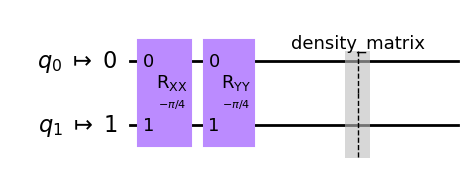

In [15]:
from qiskit.circuit.library import SiSwapGate
from qiskit import QuantumCircuit, transpile

qc = QuantumCircuit(2)
qc.append(SiSwapGate(), [0, 1])

qc = transpile(qc, noisy_simulator, basis_gates=basis_gates, coupling_map=coupling_map)
qc.save_density_matrix(list(range(N)))

qc.draw("mpl")

In [16]:
# test fidelity
from qiskit.quantum_info import state_fidelity

perfect_result = simulator.run(qc).result().data()["density_matrix"]
noisy_result = noisy_simulator.run(qc).result().data()["density_matrix"]
fidelity = state_fidelity(perfect_result, noisy_result)
print(fidelity)

0.9899979075300451


In [18]:
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit.library import SiSwapGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.quantum_info import state_fidelity, random_unitary
from mirror_gates.noisy_fidelity import T1, T2, NoiseModelBuilder
from qiskit.transpiler.coupling import CouplingMap


def fidelity_difference_1Q(p1, desired_fidelity):
    # Create a 1Q quantum circuit with a random unitary gate each iteration
    u = random_unitary(2).data
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.unitary(u, 0)
    return get_fidelity_for_p(p1[0], 0, qc, desired_fidelity)


def fidelity_difference_2Q(p2, p1, desired_fidelity):
    # 2Q quantum circuit
    qc = QuantumCircuit(2)
    qc.append(SiSwapGate(), [0, 1])
    return get_fidelity_for_p(p1, p2[0], qc, desired_fidelity)


def get_fidelity_for_p(p1, p2, qc, desired_fidelity):
    N = qc.num_qubits
    coupling_map = CouplingMap.from_line(N)
    basis_gates = ["cx", "u", "rxx", "ryy", "id"]

    builder = NoiseModelBuilder(basis_gates=basis_gates, coupling_map=coupling_map)
    builder.construct_basic_device_model(p_depol1=p1, p_depol2=p2, t1=T1, t2=T2)
    noise_model = builder.noise_model

    noisy_simulator = AerSimulator(noise_model=noise_model)
    simulator = QasmSimulator(method="density_matrix")

    qc = transpile(
        qc, noisy_simulator, basis_gates=basis_gates, coupling_map=coupling_map
    )
    qc.save_density_matrix(list(range(N)))

    perfect_result = simulator.run(qc).result().data()["density_matrix"]
    noisy_result = noisy_simulator.run(qc).result().data()["density_matrix"]
    fidelity = state_fidelity(perfect_result, noisy_result)

    return abs(fidelity - desired_fidelity)


if __name__ == "__main__":
    desired_fidelity_1Q = 0.9995
    res_1Q = minimize(
        fidelity_difference_1Q,
        [0],
        args=(desired_fidelity_1Q,),
        bounds=[(0, 0.1)],
        method="L-BFGS-B",
    )
    p1_optimal = res_1Q.x[0]

    desired_fidelity_2Q = 0.99
    res_2Q = minimize(
        fidelity_difference_2Q,
        [0],
        args=(p1_optimal, desired_fidelity_2Q),
        bounds=[(0, 0.1)],
        method="L-BFGS-B",
    )
    p2_optimal = res_2Q.x[0]

    print(p1_optimal, p2_optimal)

0.0 0.006578590068232193
